## Project 1 – Parts g & h: Bias–Variance with Bootstrap and Cross‑Validation

# Imports og hjelpefunksjoner

In [11]:
from functions import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

seed = 2018

# Make dataset

In [12]:
n_points = 2000

degrees = list(range(1, 20)) #polynomial degrees

n_boots_reps = 300 #number of bootstrap replicates
n_k_folds = 20 #number of k-folds

lambdas = np.logspace(-4, -1, 15) #feilen "straffen" i ridge og lasso

# Lag datasett
(train, test, full) = make_data(n=n_points)

x_train, y_train = train
x_test, y_test = test
x_all, y_all, y_all_clean = full 

x_grid = np.linspace(-1, 1, 400) 

# Del g: Bootstrap-estimat av Bias, Varians og MSE (OLS)

For hver polynomgrad d trener du OLS mange ganger på bootstrap-utvalg av treningsdataene. Hver gang predikerer du en hel kurve på et fast grid av x-verdier. Deretter bruker du disse mange kurvene til å anslå bias^2, varians og mse som funksjon av x (og til slutt snitter du over gridet for å få ett tall per grad).

In [13]:
boot_results = bootstrap(degrees, x_train, x_test, y_train, y_test, x_grid, n_boots_reps)

deg, bias2_boots, var_boots, mse_boots, train_mse, test_mse = (
    boot_results["degree"],
    boot_results["bias2_boots"],
    boot_results["var_boots"],
    boot_results["mse_boots"],
    boot_results["train_mse"],
    boot_results["test_mse"],
)

# Plott: Train/Test-MSE vs grad (OLS)

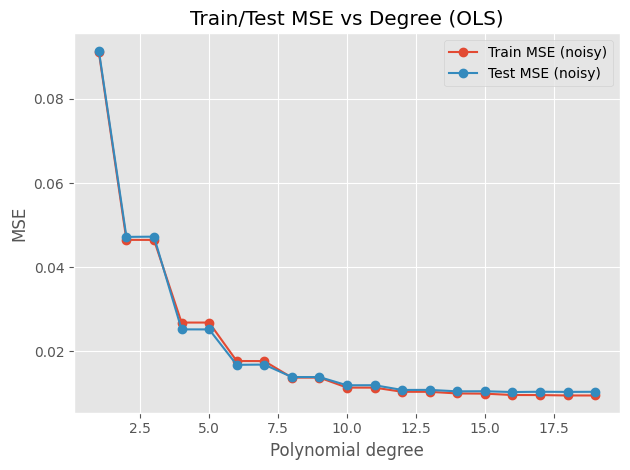

In [14]:
#for bare et bestemt number of datapoints

plt.figure()
plt.plot(deg, train_mse, marker='o', label='Train MSE (noisy)')
plt.plot(deg, test_mse, marker='o', label='Test MSE (noisy)')
plt.xlabel('Polynomial degree')
plt.ylabel('MSE')
plt.title('Train/Test MSE vs Degree (OLS)')
plt.legend()
plt.tight_layout()
plt.show()

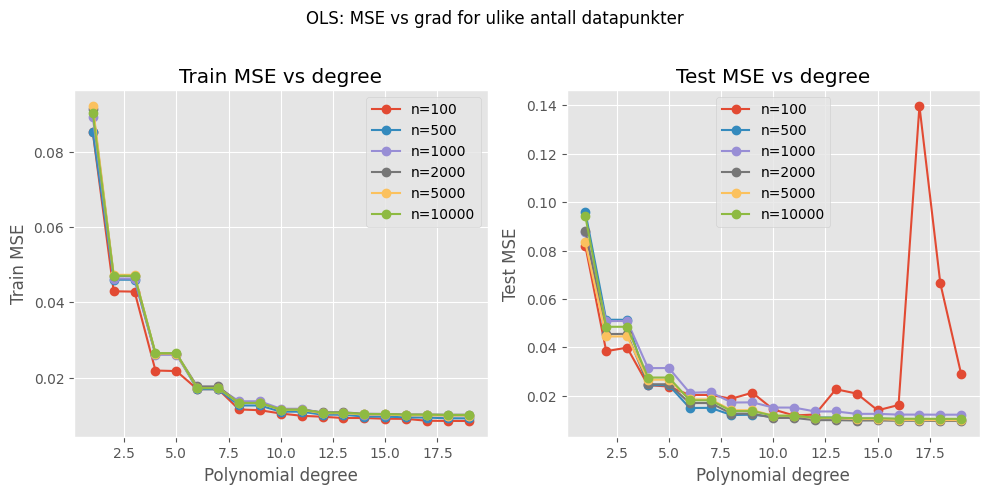

In [15]:
#for ulike datapoints

n_points_list = [100, 500, 1000, 2000, 5000, 10000]

results_by_n = {}

for n_points in n_points_list:
    # Lag datasett
    (train, test, full) = make_data(n=n_points, seed=seed)
    x_train, y_train = train
    x_test, y_test = test
    x_all, y_all, y_all_clean = full
    x_grid = np.linspace(-1, 1, 400)

    # Kjør bootstrap-rutinen din (antatt å støtte signaturen under)
    boot_results = bootstrap(
        degrees, x_train, x_test, y_train, y_test, x_grid, n_boots_reps
    )

    # Pakk ut
    deg = boot_results["degree"]
    train_mse = boot_results["train_mse"]
    test_mse  = boot_results["test_mse"]

    results_by_n[n_points] = {
        "degree": np.asarray(deg),
        "train_mse": np.asarray(train_mse),
        "test_mse": np.asarray(test_mse),
    }

# --- plotting ---
plt.figure(figsize=(10, 4.8))

# Venstre: Train MSE
plt.subplot(1, 2, 1)
for n_points in n_points_list:
    d = results_by_n[n_points]["degree"]
    tr = results_by_n[n_points]["train_mse"]
    plt.plot(d, tr, marker='o', linewidth=1.5, label=f'n={n_points}')
plt.xlabel('Polynomial degree')
plt.ylabel('Train MSE')
plt.title('Train MSE vs degree')
plt.legend()
plt.tight_layout()

# Høyre: Test MSE
plt.subplot(1, 2, 2)
for n_points in n_points_list:
    d = results_by_n[n_points]["degree"]
    te = results_by_n[n_points]["test_mse"]
    plt.plot(d, te, marker='o', linewidth=1.5, label=f'n={n_points}')
plt.xlabel('Polynomial degree')
plt.ylabel('Test MSE')
plt.title('Test MSE vs degree')
plt.legend()
plt.tight_layout()

plt.suptitle('OLS: MSE vs grad for ulike antall datapunkter', y=1.02, fontsize=12)
plt.tight_layout()
plt.show()

# (valgfritt) lagre figur
# plt.savefig('mse_vs_degree_by_npoints.png', dpi=200, bbox_inches='tight')

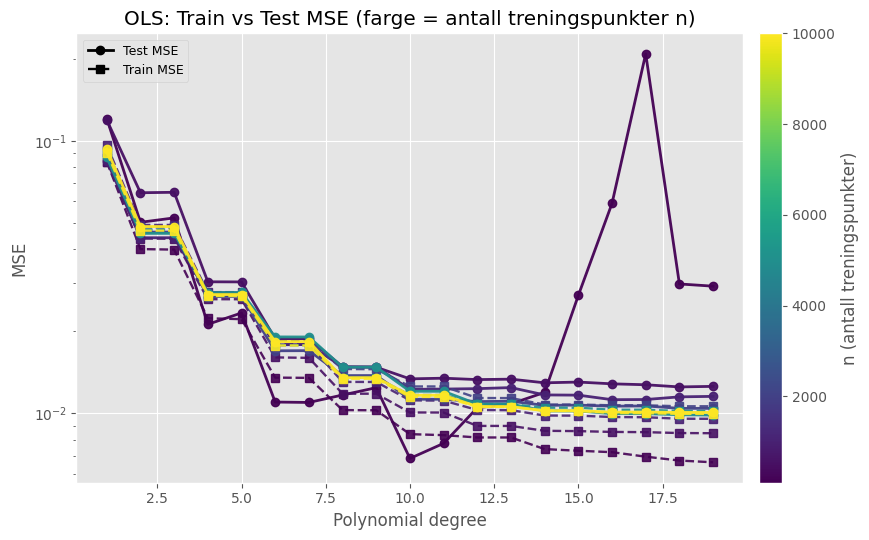

In [24]:
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np

# --- konfig ---
degrees = list(range(1, 20))
n_points_list = [100, 500, 1000, 2000, 5000, 10000]
n_boots_reps = 300

results_by_n = {}
for n_points in n_points_list:
    (train, test, full) = make_data(n=n_points, seed=seed)
    x_train, y_train = train
    x_test, y_test   = test
    x_all, y_all, y_all_clean = full
    x_grid = np.linspace(-1, 1, 400)

    boot_results = bootstrap(degrees, x_train, x_test, y_train, y_test, x_grid, n_boots_reps)
    results_by_n[n_points] = {
        "degree": np.asarray(boot_results["degree"]),
        "train_mse": np.asarray(boot_results["train_mse"]),
        "test_mse":  np.asarray(boot_results["test_mse"]),
    }

# --- fargeoppsett som "heatmap" over n ---
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=min(n_points_list), vmax=max(n_points_list))
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # triks for colorbar

fig, ax = plt.subplots(figsize=(9, 5.5))

for n_points in n_points_list:
    deg      = results_by_n[n_points]["degree"]
    train_ms = results_by_n[n_points]["train_mse"]
    test_ms  = results_by_n[n_points]["test_mse"]

    color = cmap(norm(n_points))

    # Test: heltrukket + semilog y
    ax.semilogy(deg, test_ms, marker='o', linewidth=2.0, alpha=0.95,
                label=None, color=color)

    # Train: stiplet, samme farge
    ax.plot(deg, train_ms, marker='s', linewidth=1.7, linestyle='--', alpha=0.9,
            label=None, color=color)

ax.set_xlabel('Polynomial degree')
ax.set_ylabel('MSE')
ax.set_title('OLS: Train vs Test MSE (farge = antall treningspunkter n)')

# Legg til colorbar og bind den til denne fig/axes
cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label('n (antall treningspunkter)')

# Legend for linjestil (én forklaring for Test/Train)
legend_lines = [
    Line2D([0], [0], color='black', lw=2.0, linestyle='-',  marker='o', label='Test MSE'),
    Line2D([0], [0], color='black', lw=1.7, linestyle='--', marker='s', label='Train MSE'),
]
ax.legend(handles=legend_lines, loc='best', fontsize=9)

fig.tight_layout()
plt.show()
# fig.savefig('mse_train_test_heatmap_lines.png', dpi=200, bbox_inches='tight')


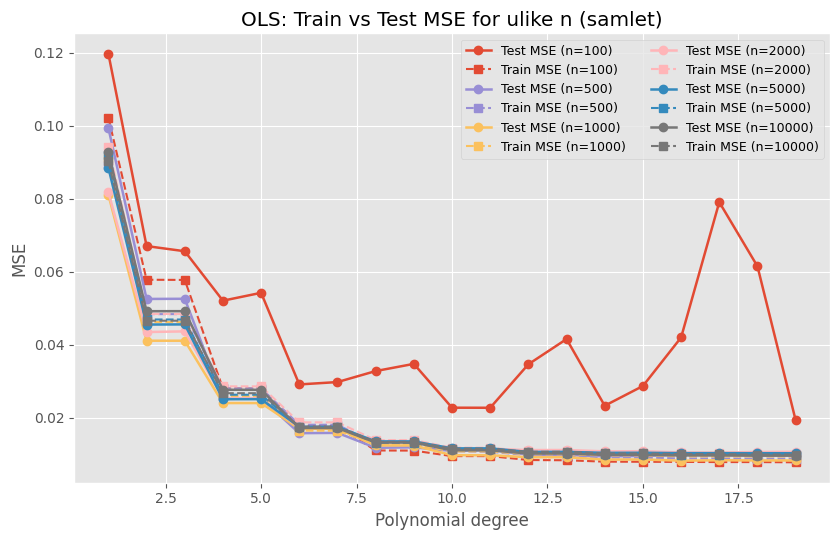

In [25]:
# --- konfig ---
degrees = list(range(1, 20))
n_points_list = [100, 500, 1000, 2000, 5000, 10000]   # <- endre/utvid etter behov
n_boots_reps = 300

results_by_n = {}

# Kjør bootstrap for alle n og lagre
for n_points in n_points_list:
    (train, test, full) = make_data(n=n_points, seed=seed)
    x_train, y_train = train
    x_test, y_test   = test
    x_all, y_all, y_all_clean = full
    x_grid = np.linspace(-1, 1, 400)

    boot_results = bootstrap(degrees, x_train, x_test, y_train, y_test, x_grid, n_boots_reps)

    results_by_n[n_points] = {
        "degree": np.asarray(boot_results["degree"]),
        "train_mse": np.asarray(boot_results["train_mse"]),
        "test_mse":  np.asarray(boot_results["test_mse"]),
    }

# --- ett samlet plott ---
plt.figure(figsize=(8.5, 5.5))

for n_points in n_points_list:
    deg = results_by_n[n_points]["degree"]
    train_mse = results_by_n[n_points]["train_mse"]
    test_mse  = results_by_n[n_points]["test_mse"]

    # Test MSE: heltrukket
    plt.plot(deg, test_mse,  marker='o', linewidth=1.8, label=f'Test MSE (n={n_points})')
    # Train MSE: stiplet (samme farge som test-linjen via _get_lines propcycle)
    # For å matche fargen, kall plot én gang til og hent siste farge:
    line = plt.plot(deg, train_mse, marker='s', linewidth=1.5, linestyle='--')[0]
    line.set_color(plt.gca().lines[-2].get_color())  # samme farge som tilsvarende test-linje
    line.set_label(f'Train MSE (n={n_points})')

plt.xlabel('Polynomial degree')
plt.ylabel('MSE')
plt.title('OLS: Train vs Test MSE for ulike n (samlet)')
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()

# (valgfritt) lagre figur:
# plt.savefig('mse_train_test_all_in_one.png', dpi=200, bbox_inches='tight')

# Plott: Bias², Varians, MSE (bootstrap) vs grad

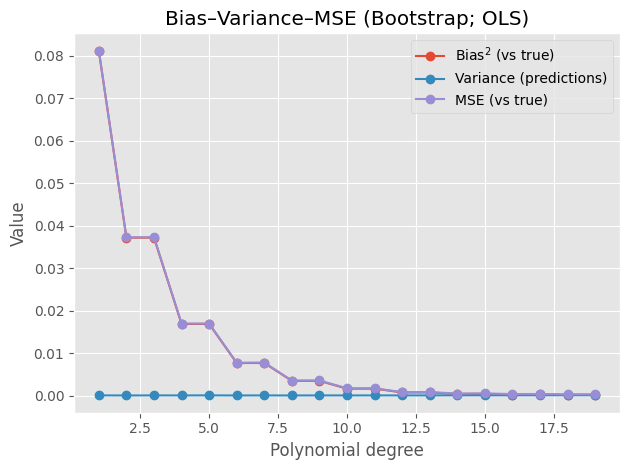

In [17]:
plt.figure()
plt.plot(deg, bias2_boots, marker='o', label='Bias$^2$ (vs true)')
plt.plot(deg, var_boots, marker='o', label='Variance (predictions)')
plt.plot(deg, mse_boots, marker='o', label='MSE (vs true)')
plt.xlabel('Polynomial degree'); plt.ylabel('Value')
plt.title('Bias–Variance–MSE (Bootstrap; OLS)')
plt.legend()
plt.tight_layout()
plt.show()

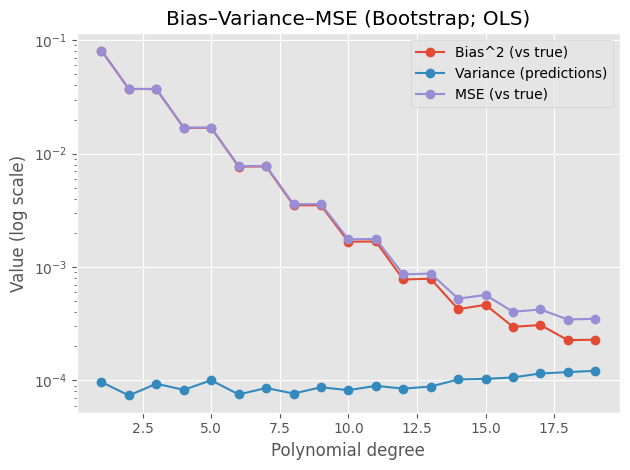

In [18]:
plt.figure()
plt.semilogy(deg, bias2_boots, marker='o', label='Bias^2 (vs true)')
plt.semilogy(deg, var_boots,   marker='o', label='Variance (predictions)')
plt.semilogy(deg, mse_boots,   marker='o', label='MSE (vs true)')
plt.xlabel('Polynomial degree'); plt.ylabel('Value (log scale)')
plt.title('Bias–Variance–MSE (Bootstrap; OLS)')
plt.legend(); plt.tight_layout(); plt.show()

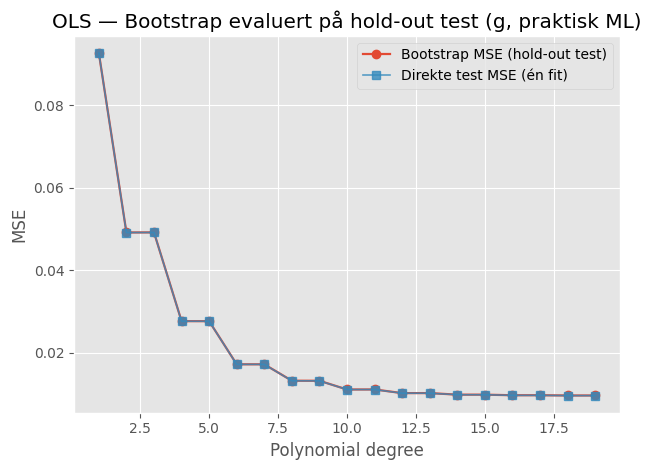

In [27]:
plt.figure()
plt.plot(deg, boot_results["mse_boots_test"], marker='o', linewidth=1.6,
         label='Bootstrap MSE (hold-out test)')
# valgfritt: legg på direkte test-MSE fra én fit per grad (referanse)
plt.plot(deg, boot_results["test_mse"], marker='s', linewidth=1.2, alpha=0.8,
         label='Direkte test MSE (én fit)')

plt.xlabel('Polynomial degree')
plt.ylabel('MSE')
plt.title('OLS — Bootstrap evaluert på hold-out test (g, praktisk ML)')
plt.legend()
plt.tight_layout()
plt.show()

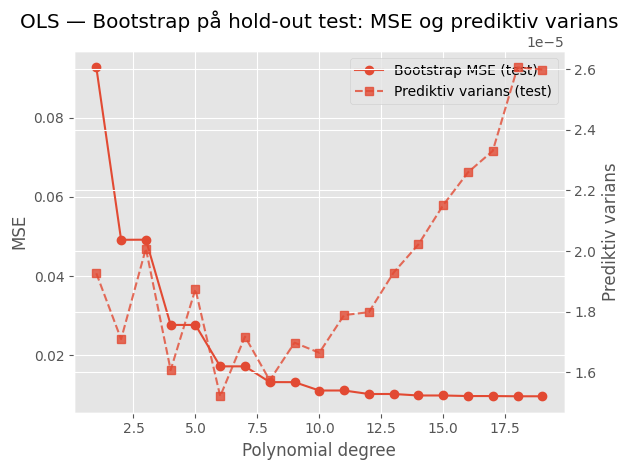

In [31]:
fig, ax = plt.subplots()
ax.plot(deg, boot_results["mse_boots_test"], marker='o', label='Bootstrap MSE (test)')
ax.set_xlabel('Polynomial degree'); ax.set_ylabel('MSE')

ax2 = ax.twinx()
ax2.plot(deg, boot_results["var_boots_test_pred"], marker='s', linestyle='--',
         alpha=0.8, label='Prediktiv varians (test)')
ax2.set_ylabel('Prediktiv varians')

# én felles legend
lines = ax.get_lines() + ax2.get_lines()
ax.legend(lines, [l.get_label() for l in lines], loc='upper right')

ax.set_title('OLS — Bootstrap på hold-out test: MSE og prediktiv varians')
plt.tight_layout(); plt.show()

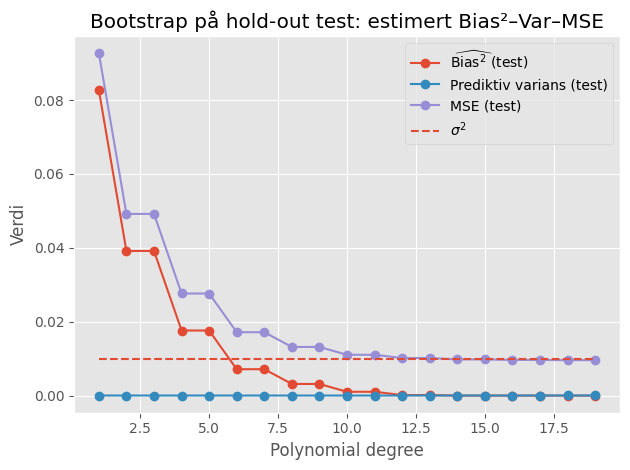

In [30]:
sigma2 = 0.1**2
deg     = boot_results["degree"]
mse_t   = boot_results["mse_boots_test"]
var_pred= boot_results["var_boots_test_pred"]

bias2_est = np.clip(mse_t - var_pred - sigma2, 0.0, None)

plt.figure()
plt.plot(deg, bias2_est, marker='o', label=r'$\widehat{\mathrm{Bias}^2}$ (test)')
plt.plot(deg, var_pred,  marker='o', label='Prediktiv varians (test)')
plt.plot(deg, mse_t,     marker='o', label='MSE (test)')
plt.hlines(sigma2, xmin=deg.min(), xmax=deg.max(), linestyles='--', label=r'$\sigma^2$')
plt.xlabel('Polynomial degree'); plt.ylabel('Verdi')
plt.title('Bootstrap på hold-out test: estimert Bias²–Var–MSE')
plt.legend(); plt.tight_layout(); plt.show()

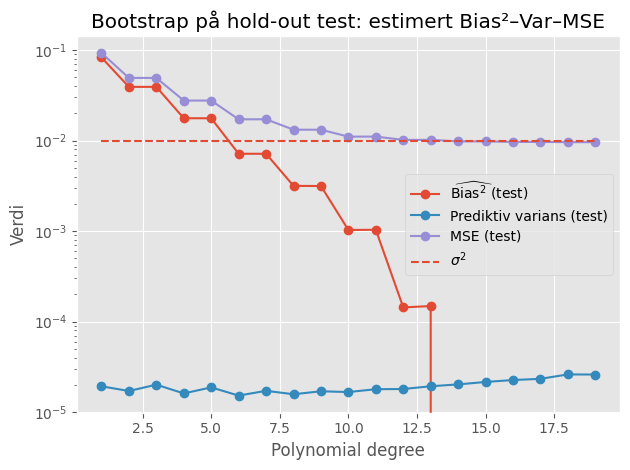

In [33]:
sigma2 = 0.1**2
deg     = boot_results["degree"]
mse_t   = boot_results["mse_boots_test"]
var_pred= boot_results["var_boots_test_pred"]

bias2_est = np.clip(mse_t - var_pred - sigma2, 0.0, None)

plt.figure()
plt.semilogy(deg, bias2_est, marker='o', label=r'$\widehat{\mathrm{Bias}^2}$ (test)')
plt.semilogy(deg, var_pred,  marker='o', label='Prediktiv varians (test)')
plt.semilogy(deg, mse_t,     marker='o', label='MSE (test)')
plt.hlines(sigma2, xmin=deg.min(), xmax=deg.max(), linestyles='--', label=r'$\sigma^2$')
plt.xlabel('Polynomial degree'); plt.ylabel('Verdi')
plt.title('Bootstrap på hold-out test: estimert Bias²–Var–MSE')
plt.legend(); plt.tight_layout(); plt.show()

# Del h: k-fold CV for OLS – MSE vs grad

In [ ]:
cv_mse_ols = np.array([kfold_cv_mse_ols(d, n_k_folds, x_train, y_train) for d in degrees])

# Plot

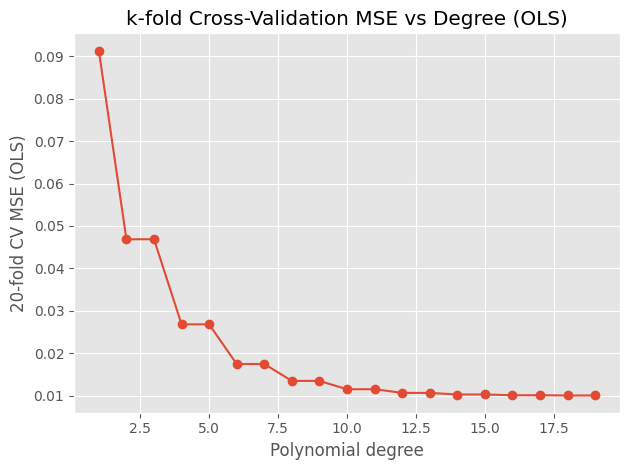

The best polynomial degree for ols is 18


In [ ]:
plt.figure()
plt.plot(degrees, cv_mse_ols, marker='o')
plt.xlabel('Polynomial degree')
plt.ylabel(f'{n_k_folds}-fold CV MSE (OLS)')
plt.title('k-fold Cross-Validation MSE vs Degree (OLS)')
plt.tight_layout()
plt.show()
best_deg_ols = int(degrees[np.argmin(cv_mse_ols)])

print(f"The best polynomial degree for ols is {best_deg_ols}")

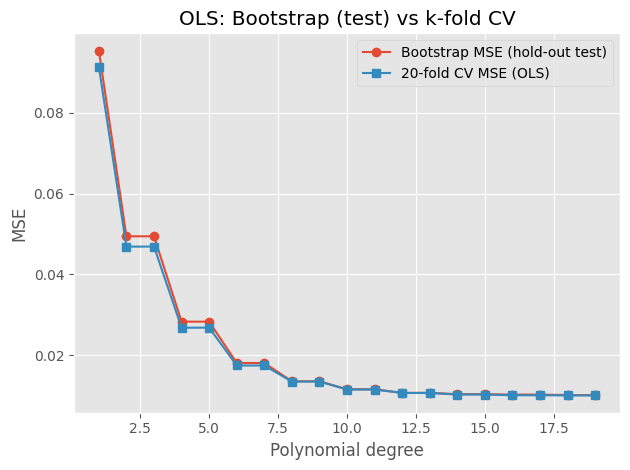

In [ ]:
cv_mse_ols = np.array([kfold_cv_mse_ols(d, n_k_folds, x_train, y_train) for d in degrees])

plt.figure()
plt.plot(deg, boot["mse_boots_test"], marker='o', label='Bootstrap MSE (hold-out test)')
plt.plot(deg, cv_mse_ols,            marker='s', label=f'{n_k_folds}-fold CV MSE (OLS)')
plt.xlabel('Polynomial degree'); plt.ylabel('MSE')
plt.title('OLS: Bootstrap (test) vs k-fold CV')
plt.legend(); plt.tight_layout(); plt.show()

# CV-kurver for Ridge og Lasso (utvalgte grader)

In [ ]:
best_ridge, best_lasso = {}, {}

cv_mse_ridge = {d: cv_for_methods('ridge', d, lambdas, n_k_folds, x_train, y_train)
for d in degrees}
cv_mse_lasso = {d: cv_for_methods('lasso', d, lambdas, n_k_folds, x_train, y_train) 
for d in degrees}

# Plot

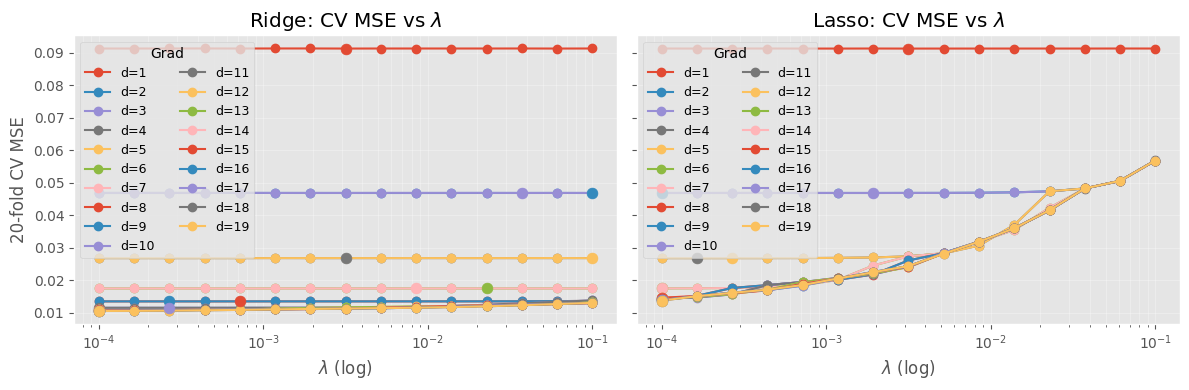

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey = True)
ax_ridge, ax_lasso = axes 

#Ridge 
for d in degrees:
    results_ridge = cv_mse_ridge[d]
    order = np.argsort(results_ridge["lambdas"])
    ax_ridge.semilogx(results_ridge["lambdas"][order], results_ridge["cv_mse"][order], marker='o', linewidth=1.5, label=f'd={d}')
    ax_ridge.scatter(results_ridge["best_lambda"], results_ridge["best_mse"], s=60, zorder=3)

ax_ridge.set_title(r'Ridge: CV MSE vs $\lambda$')
ax_ridge.set_xlabel(r'$\lambda$ (log)')
ax_ridge.set_ylabel(f'{n_k_folds}-fold CV MSE')
ax_ridge.grid(True, which='both', alpha=0.3)
ax_ridge.legend(title='Grad', ncol=2, fontsize=9)


# Lasso
for d in degrees:
    results_lasso = cv_mse_lasso[d]
    order = np.argsort(results_lasso["lambdas"])
    ax_lasso.semilogx(results_lasso["lambdas"][order], results_lasso["cv_mse"][order], marker='o', linewidth=1.5, label=f'd={d}')
    ax_lasso.scatter(results_lasso["best_lambda"], results_lasso["best_mse"], s=60, zorder=3)

ax_lasso.set_title(r'Lasso: CV MSE vs $\lambda$')
ax_lasso.set_xlabel(r'$\lambda$ (log)')
ax_lasso.grid(True, which='both', alpha=0.3)
ax_lasso.legend(title='Grad', ncol=2, fontsize=9)

plt.tight_layout()
plt.show()

/var/folders/fx/wpg9z13d2txbkzb0k2djblzh0000gn/T/ipykernel_43577/2745310613.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("viridis")  # eller "plasma", "magma", "cividis", ...
/var/folders/fx/wpg9z13d2txbkzb0k2djblzh0000gn/T/ipykernel_43577/2745310613.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


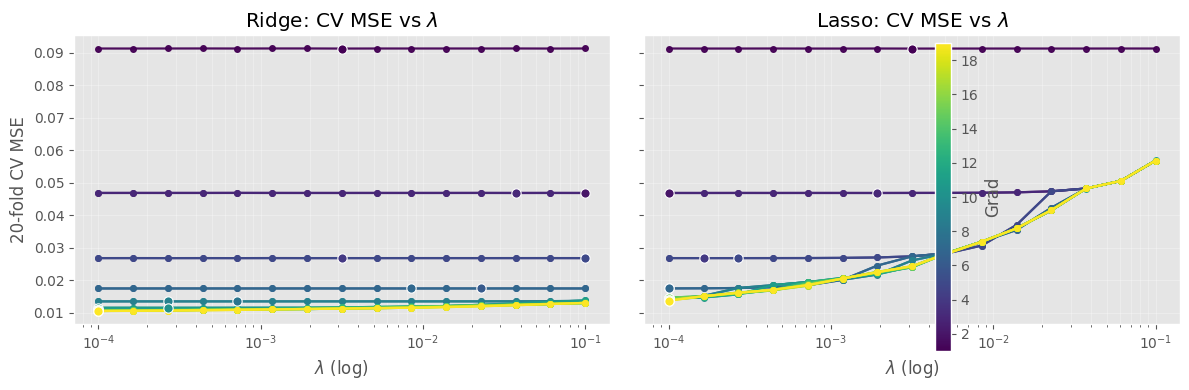

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
ax_ridge, ax_lasso = axes

# --- én fargeskala for grad ---
deg_min, deg_max = min(degrees), max(degrees)
norm = Normalize(vmin=deg_min, vmax=deg_max)
cmap = get_cmap("viridis")  # eller "plasma", "magma", "cividis", ...

def color_for_degree(d):
    return cmap(norm(d))

# RIDGE
for d in degrees:
    res = cv_mse_ridge[d]
    order = np.argsort(res["lambdas"])
    x = res["lambdas"][order]
    y = res["cv_mse"][order]
    c = color_for_degree(d)

    ax_ridge.semilogx(x, y, marker='o', linewidth=1.6, markersize=4, color=c, alpha=0.95)
    ax_ridge.scatter(res["best_lambda"], res["best_mse"], s=45, zorder=3,
                     color=c, edgecolor="white", linewidth=0.8)

ax_ridge.set_title(r'Ridge: CV MSE vs $\lambda$')
ax_ridge.set_xlabel(r'$\lambda$ (log)')
ax_ridge.set_ylabel(f'{n_k_folds}-fold CV MSE')
ax_ridge.grid(True, which='both', alpha=0.3)

# LASSO
for d in degrees:
    res = cv_mse_lasso[d]
    order = np.argsort(res["lambdas"])
    x = res["lambdas"][order]
    y = res["cv_mse"][order]
    c = color_for_degree(d)

    ax_lasso.semilogx(x, y, marker='o', linewidth=1.6, markersize=4, color=c, alpha=0.95)
    ax_lasso.scatter(res["best_lambda"], res["best_mse"], s=45, zorder=3,
                     color=c, edgecolor="white", linewidth=0.8)

ax_lasso.set_title(r'Lasso: CV MSE vs $\lambda$')
ax_lasso.set_xlabel(r'$\lambda$ (log)')
ax_lasso.grid(True, which='both', alpha=0.3)

# Felles colorbar for grad
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # nødvendig for colorbar
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), pad=0.02)
cbar.set_label('Grad')

plt.tight_layout()
plt.show()

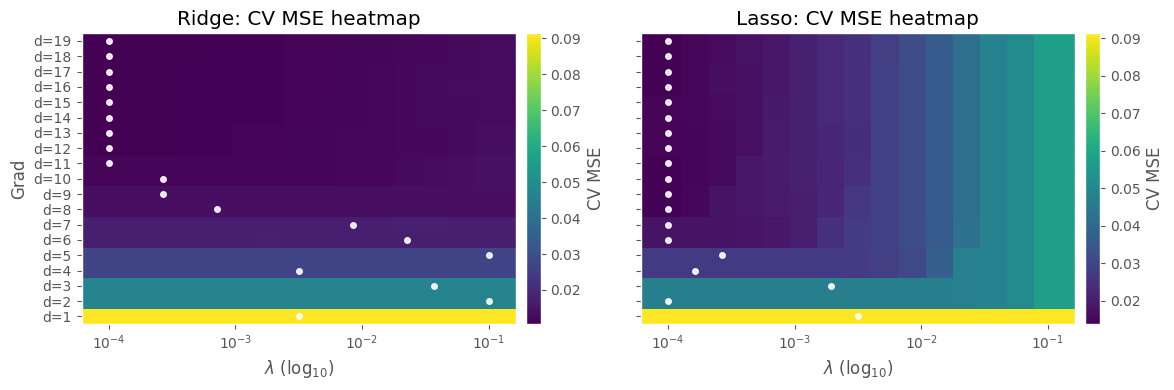

In [ ]:
def _build_heatmap_matrix(results_by_deg):
    """
    results_by_deg: dict[d] -> {"lambdas": array, "cv_mse": array, "best_lambda": float, "best_mse": float}
    Returnerer:
        degrees_sorted (list),
        lambdas_common (array),
        H (2D array shape [n_deg, n_lam]) med CV-MSE,
        best_points (list of tuples (row_i, best_lambda, best_mse))
    """
    degrees_sorted = sorted(results_by_deg.keys())
    # Samle ALLE lambdaer (kan være identiske for alle d; hvis ikke, lager vi felles grid)
    all_lams = np.unique(np.concatenate([np.asarray(results_by_deg[d]["lambdas"]) for d in degrees_sorted]))
    # Vi jobber i log10-rom for jevnere interpolasjon og akse
    lam_log = np.log10(all_lams)
    lam_log.sort()
    lambdas_common = 10**lam_log

    H = np.zeros((len(degrees_sorted), len(lambdas_common)))
    best_points = []

    for i, d in enumerate(degrees_sorted):
        lam_d = np.asarray(results_by_deg[d]["lambdas"])
        mse_d = np.asarray(results_by_deg[d]["cv_mse"])
        order = np.argsort(lam_d)
        lam_d = lam_d[order]
        mse_d = mse_d[order]
        # Interpoler i log-lambda
        H[i, :] = np.interp(lam_log, np.log10(lam_d), mse_d)
        best_points.append((i, results_by_deg[d]["best_lambda"], results_by_deg[d]["best_mse"]))
    return degrees_sorted, lambdas_common, H, best_points

# Bygg matriser
deg_r, lam_r, H_r, best_r = _build_heatmap_matrix(cv_mse_ridge)
deg_l, lam_l, H_l, best_l = _build_heatmap_matrix(cv_mse_lasso)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
axR, axL = axes

def _plot_heat(ax, lambdas, degrees, H, title, best_points):
    # x-akse i log10(lambda) men viser ticklabels som lambda
    x = np.log10(lambdas)
    # pcolormesh trenger kant-gitter; lag fra sentre
    x_edges = np.concatenate(([x[0] - (x[1]-x[0])], (x[:-1]+x[1:])/2, [x[-1] + (x[-1]-x[-2])]))
    y = np.arange(len(degrees), dtype=float)
    y_edges = np.concatenate(([y[0]-0.5], y[1:]-0.5, [y[-1]+0.5]))

    mesh = ax.pcolormesh(x_edges, y_edges, H, shading='auto')
    cbar = plt.colorbar(mesh, ax=ax, pad=0.02)
    cbar.set_label('CV MSE')

    # Marker beste punkt per grad
    for row_i, blam, bmse in best_points:
        ax.plot(np.log10(blam), row_i, marker='o', markersize=4, mec='white', mfc='white', alpha=0.9)

    ax.set_title(title)
    ax.set_xlabel(r'$\lambda$ (log$_{10}$)')
    ax.set_yticks(np.arange(len(degrees)))
    ax.set_yticklabels([f'd={d}' for d in degrees])
    ax.grid(False)

    # Penere x-ticks: velg noen få lambda-verdier
    xticks_log = np.log10(np.array([1e-4, 1e-3, 1e-2, 1e-1]))
    ax.set_xticks(xticks_log)
    ax.set_xticklabels([r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$'])

_plot_heat(axR, lam_r, deg_r, H_r, 'Ridge: CV MSE heatmap', best_r)
axR.set_ylabel('Grad')

_plot_heat(axL, lam_l, deg_l, H_l, 'Lasso: CV MSE heatmap', best_l)

plt.tight_layout()
plt.show()


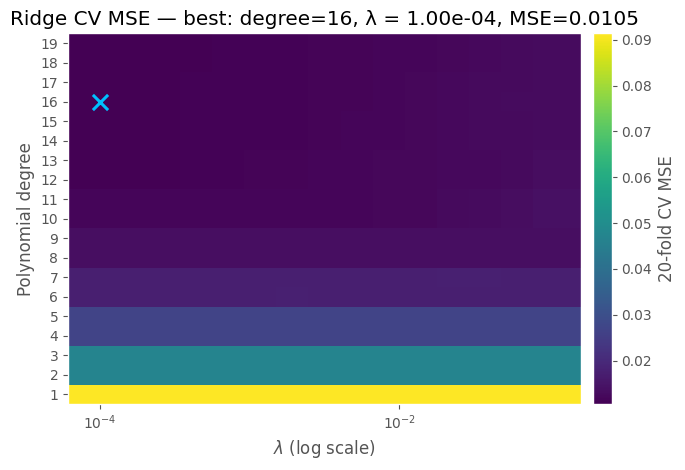

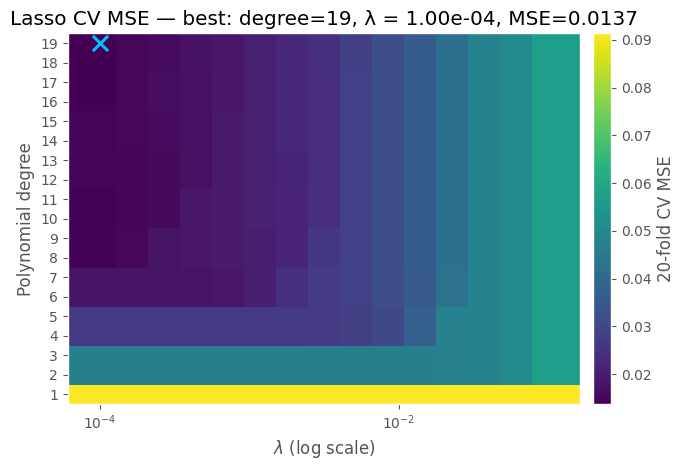

Best by CV (heatmap) — Ridge: {'degree': 16, 'lambda': np.float64(0.0001), 'cv_mse': np.float64(0.01050462456719891)}
Best by CV (heatmap) — Lasso: {'degree': 19, 'lambda': np.float64(0.0001), 'cv_mse': np.float64(0.01371299254971126)}


In [ ]:
def _build_heatmap_matrix(results_by_deg):
    degrees_sorted = sorted(results_by_deg.keys())
    all_lams = np.unique(np.concatenate(
        [np.asarray(results_by_deg[d]["lambdas"]) for d in degrees_sorted]
    ))
    lam_log = np.log10(all_lams); lam_log.sort()
    lambdas_common = 10**lam_log

    H = np.zeros((len(degrees_sorted), len(lambdas_common)))
    for i, d in enumerate(degrees_sorted):
        lam_d = np.asarray(results_by_deg[d]["lambdas"])
        mse_d = np.asarray(results_by_deg[d]["cv_mse"])
        order = np.argsort(lam_d)
        H[i, :] = np.interp(lam_log, np.log10(lam_d[order]), mse_d[order])
    return degrees_sorted, lambdas_common, H

def plot_cv_heatmap_with_best(results_by_deg, title_prefix, n_k_folds=10, cmap="viridis"):
    degrees_sorted, lambdas_common, H = _build_heatmap_matrix(results_by_deg)

    # global best in the heatmap
    i_star, j_star = np.unravel_index(np.argmin(H), H.shape)
    d_star = degrees_sorted[i_star]
    lam_star = lambdas_common[j_star]
    mse_star = H[i_star, j_star]

    fig, ax = plt.subplots(figsize=(7.0, 4.8))

    # make pcolormesh from centers (log λ on x, degree index on y)
    x = np.log10(lambdas_common)
    x_edges = np.concatenate(([x[0]-(x[1]-x[0])], (x[:-1]+x[1:])/2, [x[-1]+(x[-1]-x[-2])]))
    y = np.arange(len(degrees_sorted), dtype=float)
    y_edges = np.concatenate(([y[0]-0.5], y[1:]-0.5, [y[-1]+0.5]))

    mesh = ax.pcolormesh(x_edges, y_edges, H, shading='auto', cmap=cmap)
    cbar = plt.colorbar(mesh, ax=ax, pad=0.02)
    cbar.set_label(f'{n_k_folds}-fold CV MSE')

    # mark global best with a cross
    ax.scatter(np.log10(lam_star), i_star, marker='x', s=120, linewidths=2.2, color='deepskyblue', zorder=3)

    ax.set_title(f"{title_prefix} — best: degree={d_star}, λ = {lam_star:.2e}, MSE={mse_star:.4f}")
    ax.set_xlabel(r'$\lambda$ (log scale)')
    ax.set_ylabel('Polynomial degree')
    ax.set_yticks(np.arange(len(degrees_sorted)))
    ax.set_yticklabels([str(d) for d in degrees_sorted])
    xticks = np.array([1e-6, 1e-4, 1e-2, 1e0, 1e2])
    xticks = xticks[(xticks>=lambdas_common.min()) & (xticks<=lambdas_common.max())]
    if len(xticks) > 0:
        ax.set_xticks(np.log10(xticks))
        ax.set_xticklabels([fr'$10^{{{int(np.log10(t))}}}$' for t in xticks])

    plt.tight_layout()
    plt.show()

    return {"degree": d_star, "lambda": lam_star, "cv_mse": mse_star}

# === Use it after you’ve computed cv_mse_ridge / cv_mse_lasso ===
best_ridge_cv = plot_cv_heatmap_with_best(cv_mse_ridge, 'Ridge CV MSE', n_k_folds=n_k_folds)
best_lasso_cv = plot_cv_heatmap_with_best(cv_mse_lasso, 'Lasso CV MSE', n_k_folds=n_k_folds)

print("Best by CV (heatmap) — Ridge:", best_ridge_cv)
print("Best by CV (heatmap) — Lasso:", best_lasso_cv)


# Sammenlign OLS/Ridge/Lasso og vis beste modeller

In [ ]:
best_ridge = cv_mse_ridge
best_lasso = cv_mse_lasso

rows = []
for d in degrees:
    ols_cv_mse = kfold_cv_mse_ols(d, n_k_folds, x_train, y_train)

    rr = best_ridge[d]; ll = best_lasso[d]
    rows.append({
        "degree": d,
        "ols_cv_mse": ols_cv_mse,
        "ridge_best_lambda": rr["best_lambda"],
        "ridge_best_mse": rr["best_mse"],
        "lasso_best_lambda": ll["best_lambda"],
        "lasso_best_mse": ll["best_mse"],
    })
summary_df = pd.DataFrame(rows).sort_values("degree").reset_index(drop=True)

summary_df

,degree,ols_cv_mse,ridge_best_lambda,ridge_best_mse,lasso_best_lambda,lasso_best_mse
0,1,0.091361,0.003162,0.091351,0.003162,0.091343
1,2,0.046855,0.100000,0.046852,0.000100,0.046853
2,3,0.046869,0.037276,0.046868,0.001931,0.046858
3,4,0.026792,0.003162,0.026792,0.000164,0.026794
4,5,0.026801,0.100000,0.026793,0.000268,0.026796
5,6,0.017449,0.022758,0.017439,0.000100,0.017460
6,7,0.017457,0.008483,0.017443,0.000100,0.017464
7,8,0.013461,0.000720,0.013459,0.000100,0.014111
8,9,0.013468,0.000268,0.013464,0.000100,0.014120
9,10,0.011495,0.000268,0.011498,0.000100,0.014293


# Plott: Metodesammenligning (CV-MSE)

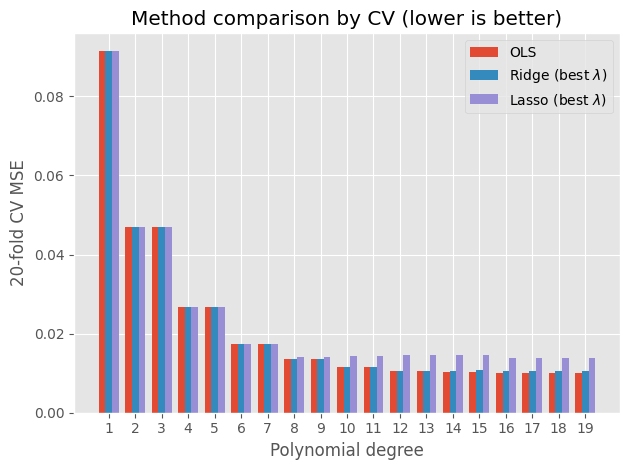

In [ ]:
idx = np.arange(len(summary_df))
width = 0.25 

plt.figure()
plt.bar(idx - width, summary_df["ols_cv_mse"], width=width, label='OLS')
plt.bar(idx,         summary_df["ridge_best_mse"], width=width, label=r'Ridge (best $\lambda$)')
plt.bar(idx + width, summary_df["lasso_best_mse"], width=width, label=r'Lasso (best $\lambda$)')
plt.xticks(idx, [str(d) for d in summary_df["degree"]])
plt.xlabel('Polynomial degree')
plt.ylabel(f'{n_k_folds}-fold CV MSE')
plt.title('Method comparison by CV (lower is better)')
plt.legend()
plt.tight_layout()
plt.show()

# Tren beste modeller og rapporter hold-out Test-MSE

OLS (deg=18) Test MSE: 0.010100
Ridge (deg=16, alpha=1.000e-04) Test MSE: 0.011106
Lasso (deg=19, alpha=1.000e-04) Test MSE: 0.017475


<>:34: SyntaxWarning: invalid escape sequence '\l'
<>:35: SyntaxWarning: invalid escape sequence '\l'
<>:34: SyntaxWarning: invalid escape sequence '\l'
<>:35: SyntaxWarning: invalid escape sequence '\l'
/var/folders/fx/wpg9z13d2txbkzb0k2djblzh0000gn/T/ipykernel_43577/1008826384.py:34: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(x_dense, ridge_model.predict(x_dense.reshape(-1,1)).ravel(), linewidth=1, label=f'Ridge (deg={best_deg_ridge}, $\lambda$={best_lambda_ridge:.2e})')
/var/folders/fx/wpg9z13d2txbkzb0k2djblzh0000gn/T/ipykernel_43577/1008826384.py:35: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(x_dense, lasso_model.predict(x_dense.reshape(-1,1)).ravel(), linewidth=1, label=f'Lasso (deg={best_deg_lasso}, $\lambda$={best_lambda_lasso:.2e})')


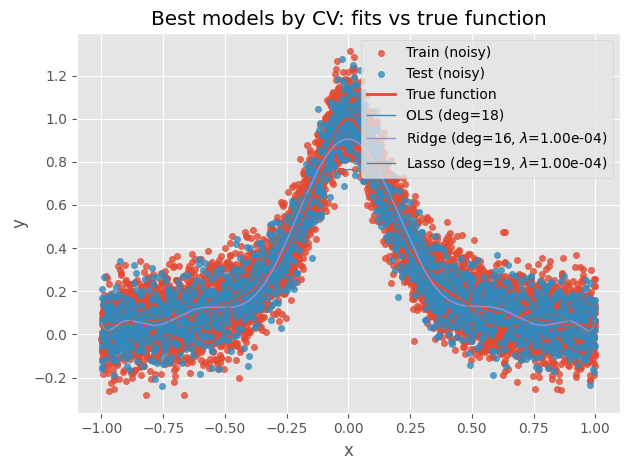

In [ ]:
# Finn beste grad for OLS fra CV
best_deg_ols = int(degrees[np.argmin(cv_mse_ols)])

# Velg beste grad/alpha for Ridge og Lasso fra tabellen
best_deg_ridge = int(summary_df.iloc[summary_df["ridge_best_mse"].idxmin()]["degree"])
best_lambda_ridge = float(summary_df.iloc[summary_df["ridge_best_mse"].idxmin()]["ridge_best_lambda"])
best_deg_lasso = int(summary_df.iloc[summary_df["lasso_best_mse"].idxmin()]["degree"])
best_lambda_lasso = float(summary_df.iloc[summary_df["lasso_best_mse"].idxmin()]["lasso_best_lambda"])

# Fit modeller
x_dense = np.linspace(-1, 1, 400)
ols_model = make_pipeline(PolynomialFeatures(degree=best_deg_ols, include_bias=False), LinearRegression(fit_intercept=True))
ols_model.fit(x_train.reshape(-1,1), y_train)
ridge_model = make_pipeline(PolynomialFeatures(degree=best_deg_ridge, include_bias=False), Ridge(alpha=best_lambda_ridge, fit_intercept=True, random_state=seed))
ridge_model.fit(x_train.reshape(-1,1), y_train)
lasso_model = make_pipeline(PolynomialFeatures(degree=best_deg_lasso, include_bias=False), Lasso(alpha=best_lambda_lasso, fit_intercept=True, max_iter=200_000_000, tol=5e-3, selection="cyclic", random_state=seed))
lasso_model.fit(x_train.reshape(-1,1), y_train)

# Test-MSE på hold-out
ols_test_mse   = mse(y_test, ols_model.predict(x_test.reshape(-1,1)).ravel())
ridge_test_mse = mse(y_test, ridge_model.predict(x_test.reshape(-1,1)).ravel())
lasso_test_mse = mse(y_test, lasso_model.predict(x_test.reshape(-1,1)).ravel())

print(f"OLS (deg={best_deg_ols}) Test MSE: {ols_test_mse:.6f}")
print(f"Ridge (deg={best_deg_ridge}, alpha={best_lambda_ridge:.3e}) Test MSE: {ridge_test_mse:.6f}")
print(f"Lasso (deg={best_deg_lasso}, alpha={best_lambda_lasso:.3e}) Test MSE: {lasso_test_mse:.6f}")

# Plot beste fits
plt.figure()
plt.scatter(x_train, y_train, s=20, alpha=0.8, label='Train (noisy)')
plt.scatter(x_test, y_test, s=20, alpha=0.8, label='Test (noisy)')
plt.plot(x_dense, f_true(x_dense), linewidth=2, label='True function')
plt.plot(x_dense, ols_model.predict(x_dense.reshape(-1,1)).ravel(), linewidth=1,label=f'OLS (deg={best_deg_ols})')
plt.plot(x_dense, ridge_model.predict(x_dense.reshape(-1,1)).ravel(), linewidth=1, label=f'Ridge (deg={best_deg_ridge}, $\lambda$={best_lambda_ridge:.2e})')
plt.plot(x_dense, lasso_model.predict(x_dense.reshape(-1,1)).ravel(), linewidth=1, label=f'Lasso (deg={best_deg_lasso}, $\lambda$={best_lambda_lasso:.2e})')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Best models by CV: fits vs true function')
plt.legend()
plt.tight_layout()
plt.show()

OLS   (deg=19)                     Test MSE: 0.010094
Ridge (deg=16, alpha=1.000e-04) Test MSE: 0.010511
Lasso (deg=19, alpha=1.000e-04) Test MSE: 0.013767


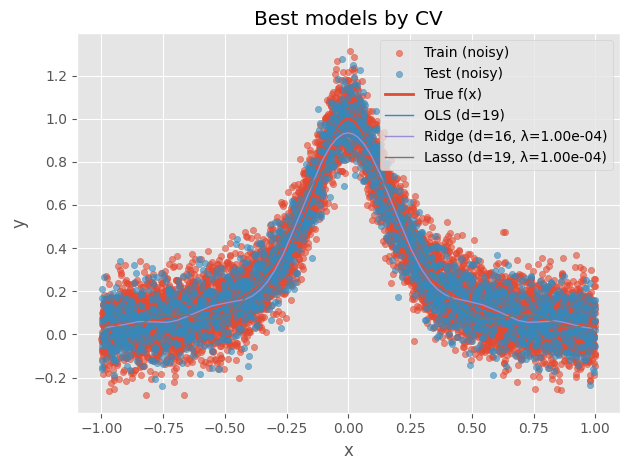

In [ ]:
best_deg_ols  = int(degrees[np.argmin(cv_mse_ols)])

# Finn globalt beste for Ridge/Lasso fra dine resultatsamlinger:
best_deg_ridge = int(summary_df.iloc[summary_df["ridge_best_mse"].idxmin()]["degree"])
best_lambda_ridge = float(summary_df.iloc[summary_df["ridge_best_mse"].idxmin()]["ridge_best_lambda"])
best_deg_lasso = int(summary_df.iloc[summary_df["lasso_best_mse"].idxmin()]["degree"])
best_lambda_lasso = float(summary_df.iloc[summary_df["lasso_best_mse"].idxmin()]["lasso_best_lambda"])

x_dense = np.linspace(-1, 1, 400)

ols_model = make_pipeline(
    PolynomialFeatures(degree=best_deg_ols, include_bias=False),
    StandardScaler(),
    LinearRegression(fit_intercept=True)
)
ols_model.fit(x_train.reshape(-1,1), y_train)

ridge_model = make_pipeline(
    PolynomialFeatures(degree=best_deg_ridge, include_bias=False),
    StandardScaler(),
    Ridge(alpha=best_lambda_ridge, fit_intercept=True, random_state=seed)
)
ridge_model.fit(x_train.reshape(-1,1), y_train)

lasso_model = make_pipeline(
    PolynomialFeatures(degree=best_deg_lasso, include_bias=False),
    StandardScaler(),
    Lasso(alpha=best_lambda_lasso, fit_intercept=True,
          max_iter=300_000, tol=1e-3, selection="cyclic", random_state=seed)
)
lasso_model.fit(x_train.reshape(-1,1), y_train)

ols_test_mse   = mse(y_test,  ols_model.predict(x_test.reshape(-1,1)).ravel())
ridge_test_mse = mse(y_test, ridge_model.predict(x_test.reshape(-1,1)).ravel())
lasso_test_mse = mse(y_test, lasso_model.predict(x_test.reshape(-1,1)).ravel())

print(f"OLS   (deg={best_deg_ols})                     Test MSE: {ols_test_mse:.6f}")
print(f"Ridge (deg={best_deg_ridge}, alpha={best_lambda_ridge:.3e}) Test MSE: {ridge_test_mse:.6f}")
print(f"Lasso (deg={best_deg_lasso}, alpha={best_lambda_lasso:.3e}) Test MSE: {lasso_test_mse:.6f}")

plt.figure()
plt.scatter(x_train, y_train, s=20, alpha=0.6, label='Train (noisy)')
plt.scatter(x_test,  y_test,  s=20, alpha=0.6, label='Test (noisy)')
plt.plot(x_dense, f_true(x_dense), linewidth=2, label='True f(x)')
plt.plot(x_dense, ols_model.predict(x_dense.reshape(-1,1)).ravel(),   linewidth=1, label=f'OLS (d={best_deg_ols})')
plt.plot(x_dense, ridge_model.predict(x_dense.reshape(-1,1)).ravel(), linewidth=1, label=f'Ridge (d={best_deg_ridge}, λ={best_lambda_ridge:.2e})')
plt.plot(x_dense, lasso_model.predict(x_dense.reshape(-1,1)).ravel(), linewidth=1, label=f'Lasso (d={best_deg_lasso}, λ={best_lambda_lasso:.2e})')
plt.xlabel('x'); plt.ylabel('y'); plt.title('Best models by CV')
plt.legend(); plt.tight_layout(); plt.show()


Tolkning:
OLS: treffer hovedformen ("en hump" rundt 0) uten å jage støy -> lav bias, moderat varians -> best generalisering her 

Ridge: lambda er ganske liten, så regulariseringen er nesten av. Med grad 12 blir kurven "bølgete", særlig mot kantene (|x| $\approx$ 1). Ser ut som høy varians/overfitting, derfor høyere test-MSE.

Lasso: med litt shrinkage, blir glattere/flatere enn OLS -> litt mer bias (undersmoothing) og mister toppens høyde -> også høyere test-mse.